In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from astropy.io import ascii

from pyia import GaiaData
import gala.coordinates as gc

In [2]:
plt.style.use('si_lgray_ucondensed')

In [9]:
tin = Table.read('../data/gd1_input_catalog.fits')

In [10]:
g = GaiaData(tin)
c = coord.SkyCoord(ra=g.ra, dec=g.dec, pm_ra_cosdec=g.pmra, pm_dec=g.pmdec)

In [20]:
def gd1_dist(phi1):
    # 0, 10
    # -60, 7
    m = (10-7) / (60)
    return (m*phi1.wrap_at(180*u.deg).value + 10) * u.kpc

wangle = 180*u.deg

In [12]:
gd1_c = c.transform_to(gc.GD1)

gd1_c_dist = gc.GD1(phi1=gd1_c.phi1, phi2=gd1_c.phi2,
                    distance=gd1_dist(gd1_c.phi1),
                    pm_phi1_cosphi2=gd1_c.pm_phi1_cosphi2,
                    pm_phi2=gd1_c.pm_phi2,
                    radial_velocity=[0]*len(gd1_c)*u.km/u.s)

# Correct for reflex motion
v_sun = coord.Galactocentric.galcen_v_sun
observed = gd1_c_dist.transform_to(coord.Galactic)
rep = observed.cartesian.without_differentials()
rep = rep.with_differentials(observed.cartesian.differentials['s'] + v_sun)
gd1_c = coord.Galactic(rep).transform_to(gc.GD1)

### full structure

In [24]:
g_ = GaiaData('../data/gd1-with-masks.fits')
stream = g_[g_.pm_mask & g_.gi_cmd_mask]

In [25]:
pmem = np.load('../output/pmem.npy')

### Radial velocities

In [13]:
tall = Table.read('../data/gd1_both.tab', format='ascii.commented_header', delimiter='\t')
ts = Table.read('../data/gd1_4_vels.tab', format='ascii.commented_header', delimiter='\t')

In [14]:
observed = tall['object']

In [15]:
c = coord.SkyCoord(ra=tin['ra']*u.degree, dec=tin['dec']*u.degree)  
catalog = coord.SkyCoord(ra=ts['rad']*u.degree, dec=ts['decd']*u.degree)  
idx, d2d, d3d = catalog.match_to_catalog_sky(c)
obs_stream = idx

In [16]:
members = ((tall['rank']<5) & (tall['VELOCITY']>-90) & (tall['VELOCITY']<-70) & 
           (tin['g'][observed]-tin['i'][observed]<0.8))
members_stream = ((ts['rank']==1) & (ts['VELOCITY']>-110) & (ts['VELOCITY']<-70) & 
           (tin['g'][obs_stream]-tin['i'][obs_stream]<0.7) & (ts['CZXCR']>3))

In [17]:
kop_vr = ascii.read("""phi1 phi2 vr err
-45.23 -0.04 28.8 6.9
-43.17 -0.09 29.3 10.2
-39.54 -0.07 2.9  8.7
-39.25 -0.22 -5.2 6.5
-37.95 0.00 1.1   5.6
-37.96 -0.00 -11.7 11.2
-35.49 -0.05 -50.4 5.2
-35.27 -0.02 -30.9 12.8
-34.92 -0.15 -35.3 7.5
-34.74 -0.08 -30.9 9.2
-33.74 -0.18 -74.3 9.8
-32.90 -0.15 -71.5 9.6
-32.25 -0.17 -71.5 9.2
-29.95 -0.00 -92.7 8.7
-26.61 -0.11 -114.2 7.3
-25.45 -0.14 -67.8 7.1
-24.86 0.01 -111.2 17.8
-21.21 -0.02 -144.4 10.5
-14.47 -0.15 -179.0 10.0
-13.73 -0.28 -191.4 7.5
-13.02 -0.21 -162.9 9.6
-12.68 -0.26 -217.2 10.7
-12.55 -0.23 -172.2 6.6""")

In [34]:
targets = {}
targets['phi1'] = np.array([-36.35, -39.5, -32.4, -29.8, -29.8])*u.deg
targets['phi2'] = np.array([0.2, 0.2, 1.1, 0, 1])*u.deg

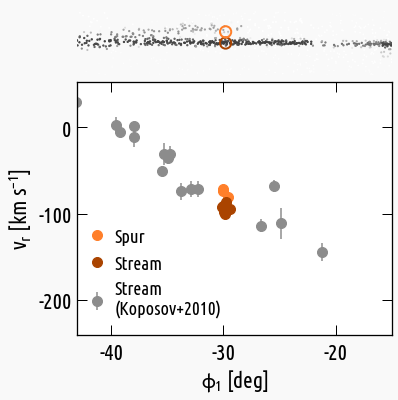

In [57]:
fig, ax = plt.subplots(2,1,figsize=(6,6), gridspec_kw = {'height_ratios':[1,4]}, sharex='col')

plt.sca(ax[0])
plt.scatter(stream.phi1, stream.phi2, s=pmem*2, c=pmem, cmap=mpl.cm.binary, vmin=0.5, vmax=1.1)

colors = ['cornflowerblue', 'lightcoral', '0.55']
colors = ['#aa4400', '#ff7f2a', '0.55']
for e, i in enumerate([3,4]):
    ac = mpl.patches.Circle((targets['phi1'][i].value, targets['phi2'][i].value), 
                               radius=0.5, fc='none', ec=colors[e], lw=2, zorder=2)
    plt.gca().add_patch(ac)
plt.gca().set_aspect('equal')
plt.ylim(-2,2)
plt.axis('off')

plt.sca(ax[1])
plt.errorbar(kop_vr['phi1'], kop_vr['vr'], yerr=kop_vr['err'], fmt='o', color=colors[2], 
             label='Stream\n(Koposov+2010)', ms=10, zorder=0)
plt.plot(gd1_c.phi1[observed][members].wrap_at(wangle), tall['VELOCITY'][members], 'o', label='Spur',
        ms=10, color=colors[1])
plt.plot(gd1_c.phi1[obs_stream][members_stream].wrap_at(wangle), ts['VELOCITY'][members_stream], 'o', label='Stream',
        ms=10, color=colors[0])

plt.legend(fontsize='small', handlelength=0.3, frameon=False)
plt.xlabel('$\phi_1$ [deg]')
plt.ylabel('$v_r$ [km s$^{-1}$]')
plt.xlim(-43,-15)

plt.tight_layout(h_pad=0)
plt.savefig('../plots/halos/vr_hectochelle.png', dpi=200)